# Quantitative Researcher Assignment - VNTrading
## Financial Time Series Analysis - Devanshu Sharma
- Some Background information
- Problem Statement:
- More details provided in the readme file

### Import standard libraries & Set up plotting styles


In [1]:
# Core data manipulation and numerical computing
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
import pandas_ta_classic as ta

# Machine learning and statistical models
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Financial specific
import yfinance as yf  # fallback for additional data if needed

# Performance optimization
from numba import jit
import multiprocessing as mp

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12# Set random seeds for reproducibility
np.random.seed(42)

### Data Extraction & Preprocessing

In [10]:
def load_data(csv_path=None, parquet_path=None):
    try:
        if parquet_path:
            df = pd.read_parquet(parquet_path)
            print("Loaded Parquet file")
        elif csv_path:
            df = pd.read_csv(csv_path)
            print("Loaded CSV file")
        else:
            raise ValueError("No file path provided")
            
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# def preprocess_time_series(df, date_column=None, value_columns=None):
#     df_clean = df.copy()
    
#     # Set datetime index
#     if date_column:
#         df_clean[date_column] = pd.to_datetime(df_clean[date_column])
#         df_clean = df_clean.set_index(date_column)
#         df_clean = df_clean.sort_index()
#         print(f"Set datetime index: {date_column}")
    
#     # Handle missing values
#     initial_missing = df_clean.isnull().sum().sum()
#     if initial_missing > 0:
#         # For time series, use forward fill then backward fill
#         df_clean = df_clean.ffill().bfill()
#         remaining_missing = df_clean.isnull().sum().sum()
#         # print(f"Missing values removed: {initial_missing}")
    
#     # Remove constant columns
#     constant_columns = [col for col in df_clean.columns if df_clean[col].nunique() <= 1]
#     if constant_columns:
#         df_clean = df_clean.drop(columns=constant_columns)
#         # print(f"Removed constant columns: {constant_columns}")
    
#     return df_clean

### Print Data Summary & Statistics
- Preprocessing not needed as the data is clean and no null values
- 

In [12]:
df = load_data("BTCUSDT_price_data_2024-01-24.csv")
# df = preprocess_time_series(df, date_column="timestamp")

####
# Remove the trailing 'T', convert to integer, then to datetime
df['timestamp'] = df['timestamp'].str.replace('T', '').astype(np.int64)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

# set as index for time-series convenience
df.set_index('datetime', inplace=True)
####

def data_overview(df):
    display(df.head())
    print(f"Shape: {df.shape}")
    print(df.info())
    print(df.describe())
    print("\nMissing values per column:")
    print(df.isnull().sum())

data_overview(df)

Loaded CSV file


,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1706054400000,39881.95,439.561
2024-01-24 00:01:00,1706054460000,39926.55,776.492
2024-01-24 00:02:00,1706054520000,39877.05,339.306
2024-01-24 00:03:00,1706054580000,39927.45,246.511
2024-01-24 00:04:00,1706054640000,39926.55,423.920


Shape: (1439, 3)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1439 entries, 2024-01-24 00:00:00 to 2024-01-24 23:58:00
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  1439 non-null   int64  
 1   mid_price  1439 non-null   float64
 2   volume     1439 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 45.0 KB
None
          timestamp     mid_price       volume
count  1.439000e+03   1439.000000  1439.000000
mean   1.706098e+12  39919.132279   189.511495
std    2.493287e+07    175.222416   223.523507
min    1.706054e+12  39516.950000    13.454000
25%    1.706076e+12  39777.600000    73.456500
50%    1.706098e+12  39917.850000   123.278000
75%    1.706119e+12  40047.700000   213.539500
max    1.706141e+12  40479.550000  2464.729000

Missing values per column:
timestamp    0
mid_price    0
volume       0
dtype: int64


### Visualize the preprocessed data 

KeyError: 'P'

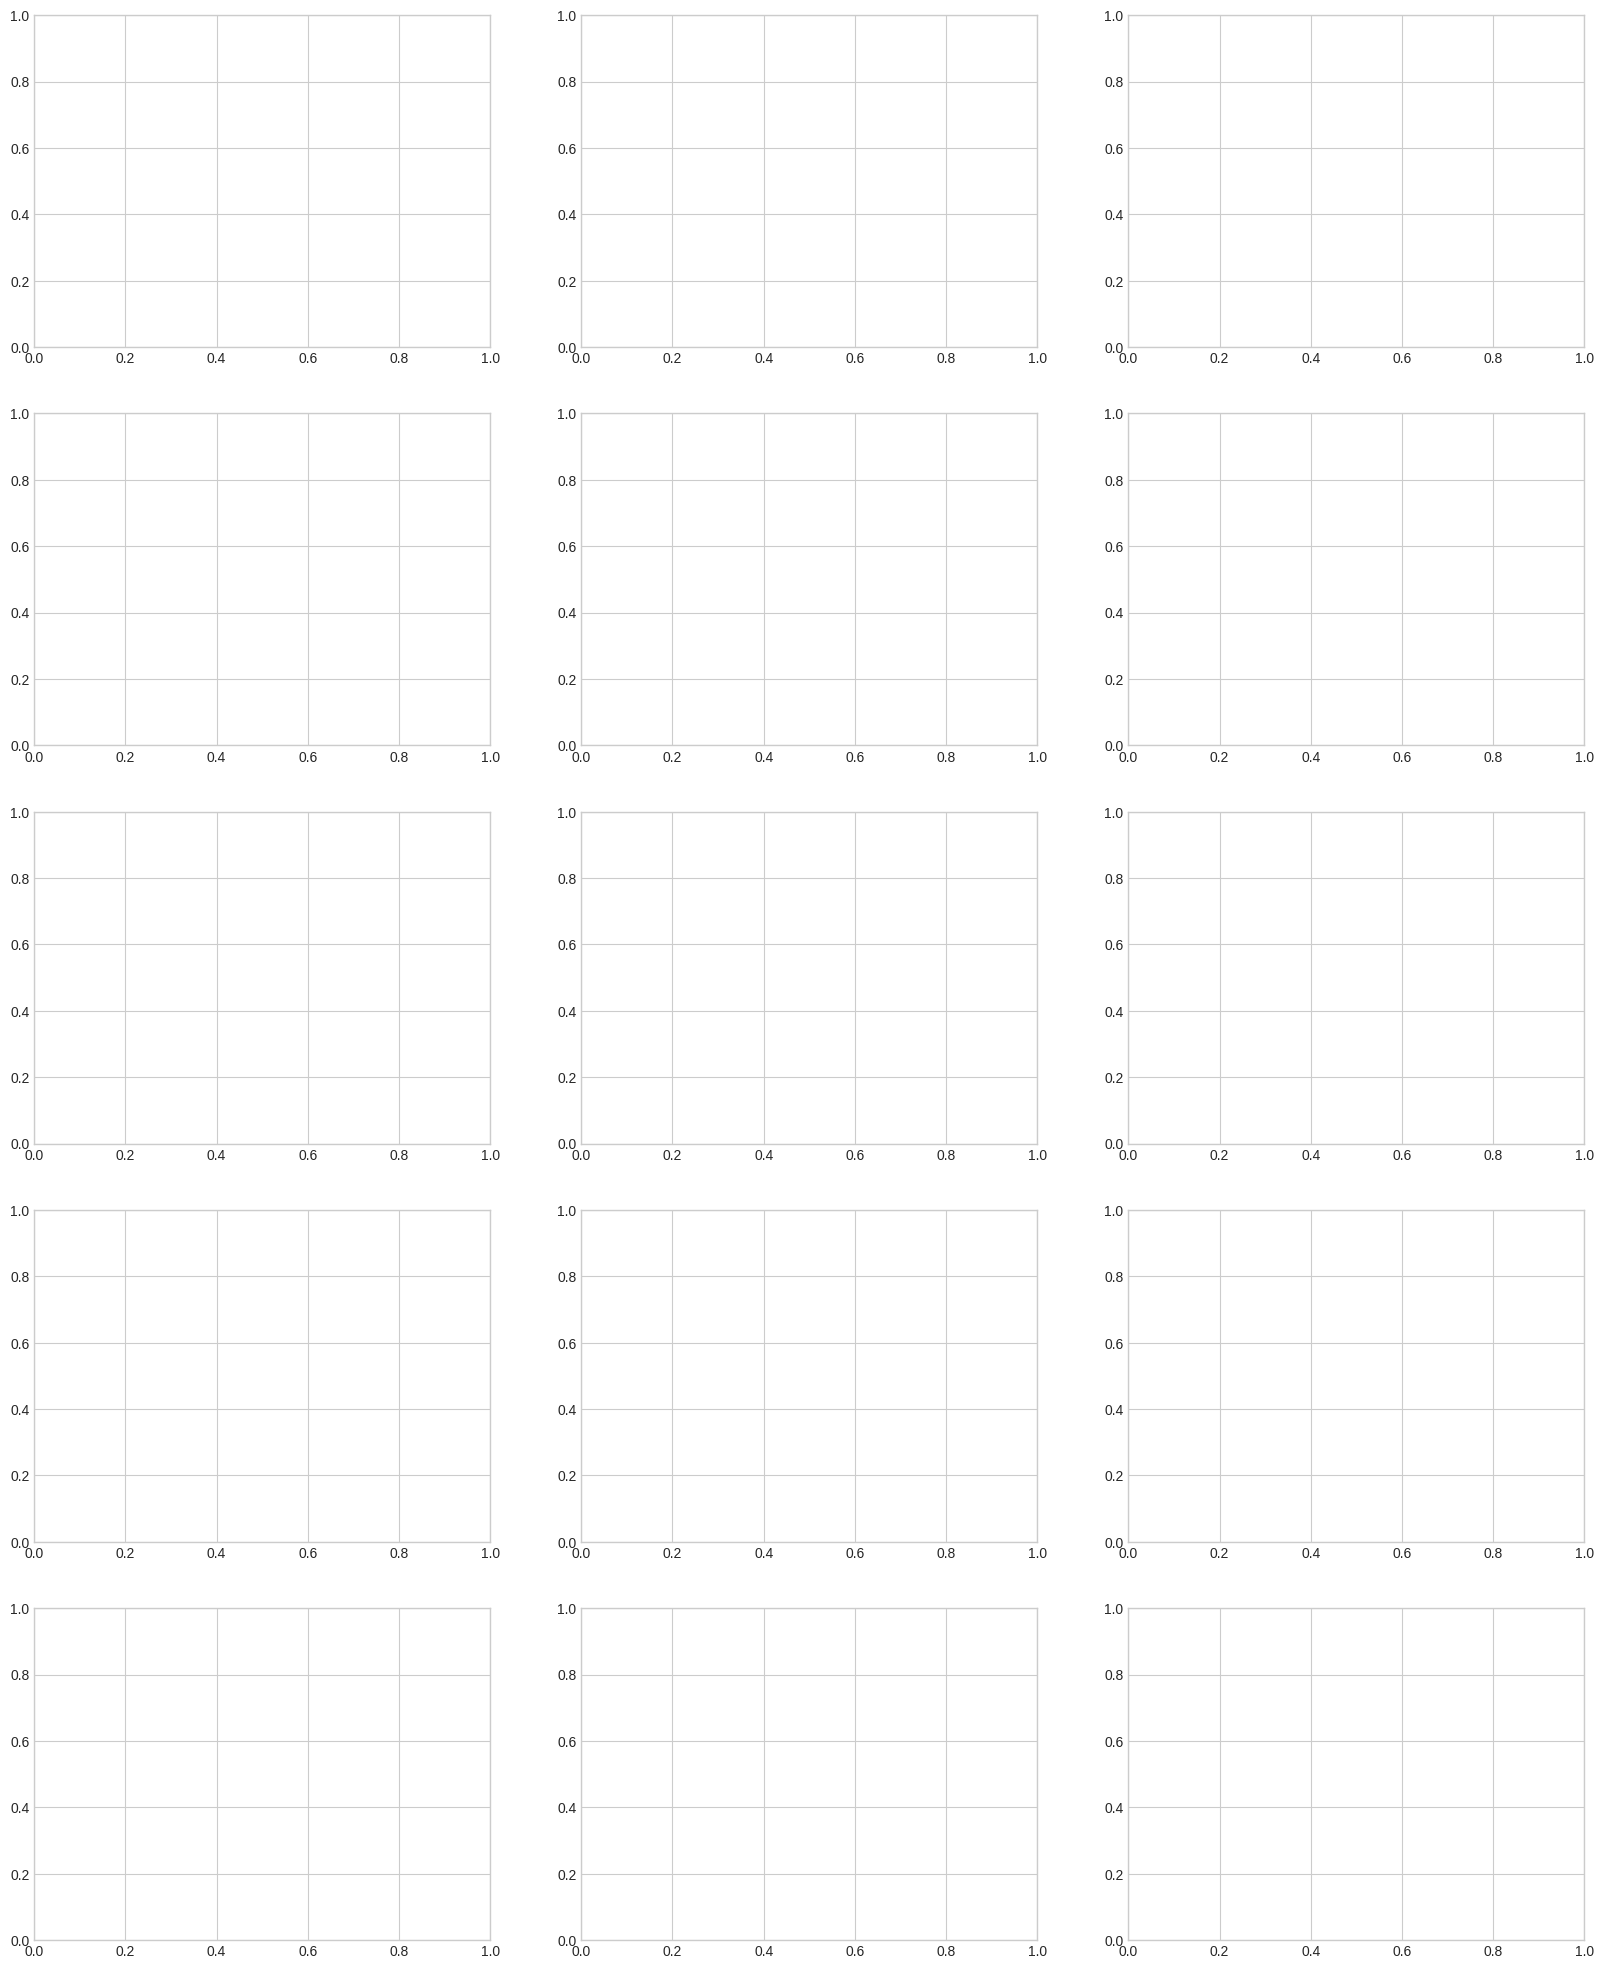

In [22]:
def plot_time_series_analysis(df, target_columns=None):

    if target_columns is None:
        target_columns = df.select_dtypes(include=[np.number]).columns[:3]  # First 3 numeric columns
    
    n_plots = len(target_columns)
    fig, axes = plt.subplots(n_plots, 3, figsize=(20, 5*n_plots))
    
    if n_plots == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(target_columns):
        # Time series plot
        axes[i, 0].plot(df.index, df[col])
        axes[i, 0].set_title(f'{col} - Time Series')
        axes[i, 0].set_ylabel('Value')
        axes[i, 0].grid(True)
        
        # Distribution
        axes[i, 1].hist(df[col].dropna(), bins=50, alpha=0.7, density=True)
        axes[i, 1].set_title(f'{col} - Distribution')
        axes[i, 1].set_ylabel('Density')
        
        # ACF plot
        plot_acf(df[col].dropna(), ax=axes[i, 2], lags=40)
        axes[i, 2].set_title(f'{col} - Autocorrelation')
    
    plt.tight_layout()
    plt.show()

def correlation_analysis(df):
    numeric_df = df.select_dtypes(include=[np.number])
    
    plt.figure(figsize=(15, 10))
    
    # Correlation heatmap
    corr_matrix = numeric_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

plot_time_series_analysis(df, target_columns="Price")

### Feature Engineering & Feature Selection
- Create Features 
- Select the most relevant features to train the model

In [ ]:
def create_financial_features(df, price_column=None):
    df_features = df.copy()
    
    numeric_columns = df_features.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        # Returns
        df_features[f'{col}_return'] = df_features[col].pct_change()
        df_features[f'{col}_log_return'] = np.log(df_features[col] / df_features[col].shift(1))
        
        # Rolling statistics
        for window in [5, 10, 20]:  # Common financial windows
            df_features[f'{col}_rolling_mean_{window}'] = df_features[col].rolling(window=window).mean()
            df_features[f'{col}_rolling_std_{window}'] = df_features[col].rolling(window=window).std()
            df_features[f'{col}_rolling_min_{window}'] = df_features[col].rolling(window=window).min()
            df_features[f'{col}_rolling_max_{window}'] = df_features[col].rolling(window=window).max()
            
            # Volatility (annualized if daily data)
            df_features[f'{col}_volatility_{window}'] = df_features[col].rolling(window=window).std() * np.sqrt(252)
        
        # Technical indicators
        df_features[f'{col}_momentum'] = df_features[col] / df_features[col].shift(5) - 1
        df_features[f'{col}_MA_ratio'] = df_features[col] / df_features[f'{col}_rolling_mean_20']
        
        # Statistical features
        df_features[f'{col}_zscore'] = (df_features[col] - df_features[col].mean()) / df_features[col].std()
    
    # Handle infinite values and NaNs created by transformations
    df_features = df_features.replace([np.inf, -np.inf], np.nan)
    df_features = df_features.ffill().bfill()
    
    print(f" Created {len(df_features.columns) - len(df.columns)} additional features")
    return df_features

# select only the relevant features
def select_features(df, ticker):
    features = df[ticker].dropna()
    return features

all_features = create_financial_features(df)

# Add more tickers if needed
selected_tickers = ["Price_return"]
selected_features = select_features(all_features, selected_tickers)

### Setup the forecasting model
- Multiple choices provided
- Select the best one according to the time constraints and underlying data
- Comment out the useless models to save time

In [ ]:
def train_test_models(self, X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42)
        # 'LightGBM': lgb.LGBMRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)
        
        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'predictions': y_pred_test
        }
        
        print(f"{name} - Test RMSE: {test_rmse:.6f}, R²: {test_r2:.6f}")
    
    return results

### Saving the results externally

In [ ]:
def save_results(results_dict, filename_prefix='DevanshuSharma_VNTrading_results'):
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    
    for name, result in results_dict.items():
        if isinstance(result, pd.DataFrame):
            result.to_csv(f'{filename_prefix}_{name}_{timestamp}.csv', index=False)
        elif isinstance(result, plt.Figure):
            result.savefig(f'{filename_prefix}_{name}_{timestamp}.png', dpi=300, bbox_inches='tight')
    
    print(f"Saved externally as: {filename_prefix}")

## Less Relevant Code

### (Optional) Interactive Plots

In [ ]:
def plot_interactive_time_series(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    fig = go.Figure()
    
    for col in columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[col],
            name=col,
            mode='lines'
        ))
    
    fig.update_layout(
        title="Time Series Analysis",
        xaxis_title="Date",
        yaxis_title="Value",
        hovermode='x unified',
        height=500
    )
    
    fig.show()

plot_interactive_time_series(df)

### Check stationarity of the time series data
- A time series data needs to be stationary in order for ARIMA model to work
- There are no such restrictions for SARIMA / SARIMAX models or Machine Learning Models
- However, it's a good practice to check for the stationarity of a time series data
- Determined with ADF test: if the p-value < 0.05, you reject the null hypothesis (that the series is non-stationary)

In [ ]:
def stationarity_analysis(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    results = []
    
    for col in columns:
        series = df[col].dropna()
        
        # Augmented Dickey-Fuller test
        adf_result = adfuller(series)
        adf_stat, adf_pvalue = adf_result[0], adf_result[1]
        
        # KPSS test
        try:
            kpss_result = kpss(series, regression='c')
            kpss_stat, kpss_pvalue = kpss_result[0], kpss_result[1]
        except:
            kpss_stat, kpss_pvalue = np.nan, np.nan
        
        results.append({
            'Series': col,
            'ADF_Statistic': adf_stat,
            'ADF_pvalue': adf_pvalue,
            'ADF_Stationary': adf_pvalue < 0.05
            # 'KPSS_Statistic': kpss_stat,
            # 'KPSS_pvalue': kpss_pvalue,
            # 'KPSS_Stationary': kpss_pvalue > 0.05 if not np.isnan(kpss_pvalue) else np.nan
        })
    
    results_df = pd.DataFrame(results)
    display(results_df)
    
    return results_df

stationarity_analysis(df)